In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl

import sys

sys.path.append('../../helper_classes')
from limit_utils import get_sensitivity_bands

2025-06-03 07:52:06.244106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748962326.264416  409532 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748962326.270679  409532 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748962326.289426  409532 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748962326.289445  409532 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748962326.289448  409532 computation_placer.cc:177] computation placer alr

In [2]:
def get_signal_rates_from_likelihood(likelihood_file):
    sys.path.append('..')
    likelihood_class = __import__('create_simple_template_likelihood', globals(), locals(), [])
    class_names = [name for name in dir(likelihood_class) if isinstance(getattr(likelihood_class, name), type)]
    globals().update({name: getattr(likelihood_class, name) for name in class_names})
    
    likelihood_container = pkl.load(open(likelihood_file, 'rb'))
    signal_expected_mean = likelihood_container.expected_signal_counts
    
    return signal_expected_mean

In [3]:
def scaling_fn(mu, mu_ref):
    return mu / mu_ref * 1e-45

Found 99 failed toy for WIMP10; removing...
Found 206 failed toy for WIMP60; removing...
Found 278 failed toy for WIMP1000; removing...


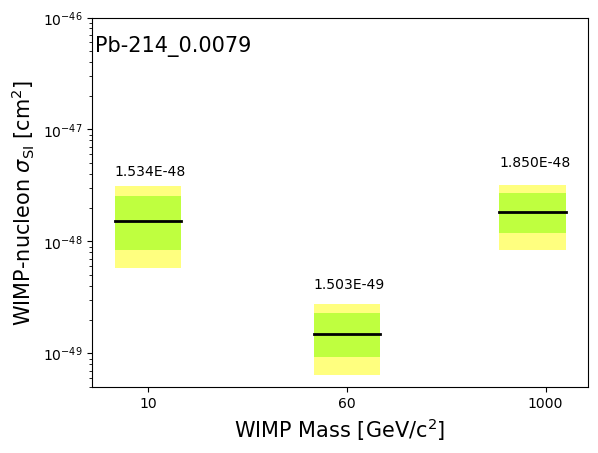

In [4]:
param = 'SI_60t_benchmark_0.0079'
param_title = 'Pb-214_0.0079'
signal_expected_mean = get_signal_rates_from_likelihood(f'../wimp_sensitivity/likelihoods/{param}.pkl')

masses, bands = get_sensitivity_bands(directory=f'../wimp_sensitivity/outputs/{param}',
                                      scaling_fn=scaling_fn,
                                      signal_name='WIMP',
                                      signal_expected_mean=signal_expected_mean,
                                      inference_config='../wimp_sensitivity/inference_configs/SI_WIMP_benchmark.ini')

fig = plt.figure()
ax = fig.gca()
delta = 0.05

ticks_plot = {0.2: 0,
              0.5: 1,
              0.78: 2}
for tick, i in ticks_plot.items():

    plt.plot([tick-delta, tick+delta],
             2*[bands[0][i]],
             color='k', linewidth=2)
    plt.fill_between([tick-delta, tick+delta],
                     2*[bands[-1][i]], 2*[bands[1][i]],
                     facecolor='#00ff00', alpha=0.5)
    plt.fill_between([tick-delta, tick+delta],
                     2*[bands[-2][i]], 2*[bands[2][i]],
                     facecolor='#ffff00', alpha=0.5)
    plt.text(tick - 0.05, bands[0][i] * 2.5, "{:.3E}".format(bands[0][i]))

plt.text(0.12, 5e-47, param_title, fontsize=15)

    

xlab = r'WIMP Mass [GeV/c$^2$]'
ax.set_xlabel(xlab, fontsize=15)
plt.xticks([0.2, 0.5, 0.8], labels=[10, 60, 1000])

ylab = r'WIMP-nucleon $\sigma_{\rm SI}$ [cm$^2$]'
ylim = (5e-50, 1e-46)
ax.set_ylabel(ylab, fontsize=15)
ax.set_ylim(ylim)

ax.set_yscale('log')

In [5]:
print(bands)

{0: [np.float64(1.5335043863041408e-48), np.float64(1.5034953749078683e-49), np.float64(1.8496141895252702e-48)], -1: [np.float64(8.421636247939598e-49), np.float64(9.216254620452704e-50), np.float64(1.1932422721070586e-48)], 1: [np.float64(2.528331297890506e-48), np.float64(2.289536949846321e-49), np.float64(2.7323189656247863e-48)], -2: [np.float64(5.80897338600847e-49), np.float64(6.45676845422504e-50), np.float64(8.465731619572051e-49)], 2: [np.float64(3.113741461688099e-48), np.float64(2.7543005860924593e-49), np.float64(3.165642255941825e-48)]}


In [6]:
print(bands[-1][0],bands[1][0], '1 sig')

print(bands[-2][0], bands[2][0], '2 sig')

8.421636247939598e-49 2.528331297890506e-48 1 sig
5.80897338600847e-49 3.113741461688099e-48 2 sig


'bands[0]' are the medians. 'bands[1&-1]' are our quartiles.

The code below saves the sensitivities into a .txt file for each WIMP mass. Everytime you run it, it adds a new row to each file.

In [7]:
# Text file names per band key
band_names = {
    0: "sensitivity",
    -1: "1_sigma_lower",
    1: "1_sigma_upper",
    -2: "2_sigma_lower",
    2: "2_sigma_upper"
}

column_headers = ["10 GeV", "60 GeV", "1000 GeV"]

#Making the subfolders for each backgroun level

counts = 0.0079
main_folder = "sen_outputs"
parent_folder = os.path.join(main_folder, f"sen_bands_{counts}")
sub_folder = os.path.join(parent_folder, "band_outputs")

os.makedirs(sub_folder, exist_ok=True)

# Save each band's values to its own file
for band_key, values in bands.items():
    title = band_names.get(band_key, "")
    filename = f"{title}.txt"
    filepath = os.path.join(sub_folder, filename)
    file_exists = os.path.isfile(filepath)

    with open(filepath, "a") as file:
        # Write header if file is new
        if not file_exists:
            file.write("\t".join(column_headers) + "\n")
        # Write the data row
        file.write("\t".join(f"{v:.18e}" for v in values) + "\n")